# Test Technique - Tannier Yannis

**Author:** [Yannis Tannier](https://github.com/yannistannier)<br>
**Date created:** 2021/10/16<br>
**Last modified:** 2021/10/19<br>

Le but de l’exercice est de présenter un problème typique de machine learning qu’on pourrait rencontrer, la classification d’image multiclasse.    
Nous vous proposons un Dataset d’images d'emoticones provenant du site ”emojipedia”. Il contient 10000 images reparties sur 50 categories (personnes, plats, activites, objets ...). 
Les images proviennent de plusieurs entreprises technologiques (Apple, Google, Samsung, Facebook...).    

Voici un exemple de certaines classes :

<img src="https://raw.githubusercontent.com/yannistannier/Icons50-bonus/master/icons-50.png" width="50%" />

L’idée est d’entrainer un classifieur capable de classifier un emoticone dans l’une des 50 catégories.

Pour répondre à la problématique, ce test technique suivra le plan suivant :
1. Résumé de l'approche et des performances obtenus
2. Preprocessing
3. Modeling et entraînement
4. Analyse des erreurs
5. Validation croisée

## I) Approche selectionnée, performances et remarques

### Approche

Pour répondre à la problématique, nous choisissons une approche par fine-tuning avec un EfficientNet et l'utilisation de AugMix.

EfficientNet (introduit par [Tan and Le, 2019](https://arxiv.org/abs/1905.11946) ) a été choisi car c'est un des modèles les plus efficace et rapide, l'inference d'un EffecientNet necessite moins de FLOPS que la plupart des autres modèles. De plus EfficientNet fait partie des architectures à l'état de l'art en classification d'image et transfert learning sur divers jeux de données notamment ImageNet.

[AugMix](https://arxiv.org/pdf/1912.02781.pdf) est une technique de traitement de données qui permet de générer de nouvelles images "augmentées". Augmix permet d'améliorer la robustesse et les mesures d'incertitudes pour des taches de classification d'image.   

Exemple d'une image augmentée par AugMix :

![test]( 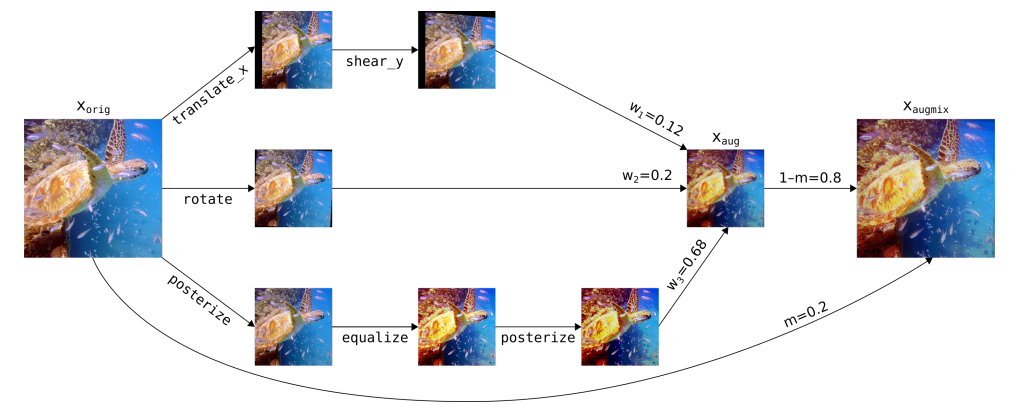)

### Jeu de données et choix des métriques d'évaluation

Le jeu de données présente 10 000 images de taille **120x120** dans 50 catégories. Un histogramme des classes nous permet de voir la distribution d'instances pour chaque classe :

![test]( 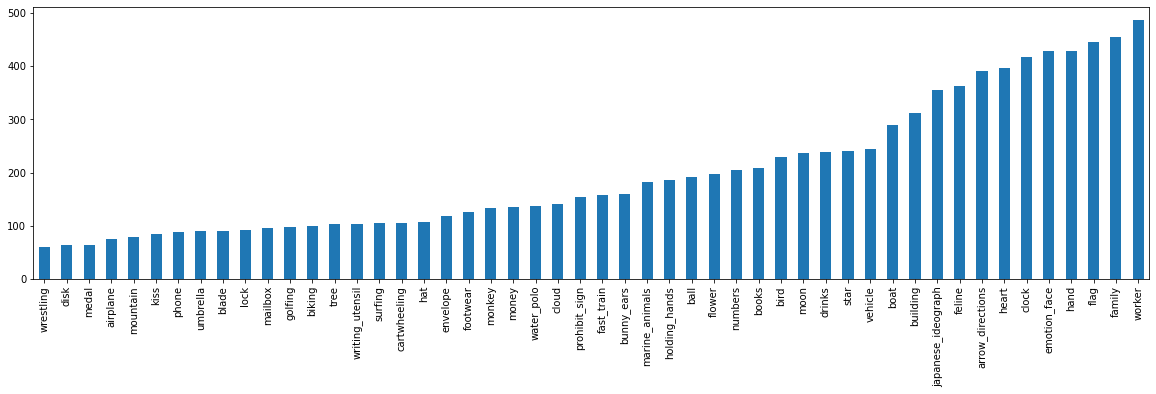)

En regardant l'histogramme, on peut voir que notre jeu de données est légèrement déséquilibré (61 images pour la plus petite classe, 487 pour la plus grande).

Concernant les métriques d'évaluation nous choisissons l'Accuracy et le F1_score :

- L'accuracy correspond au nombre de prédiction correct sur le nombre total de prédiction. C'est une bonne métrique qui permet d'évaluer la performance générale d'un modèle.     

- F1 Score combine la précision et le rappel. Cette métrique est très intéressante car le nombre de vrais négatifs n'est pas pris en compte. Un grand nombre de Vrai Negatif n'aura aucun impact sur le F1 Score, la rendant très approprié sur un jeu de données déséquilibré

Dans notre cas, le déséquilibré n'est pas assez prononcé pour exclure l'Accuracy comme métrique. Dans la pratique nous verrons plus tard que l'Accuracy et le f1_score nous donnent des résultats quasiment identiques.

### Performances et remarques

Notre approche sera évaluée en deux temps : Une première fois en "Single Model" où l'on essayera d'obtenir les meilleures performances (F1/Acc) sur un entrainement. Et une deuxième fois par **validation croisée à k=5 blocs**. Les métriques (Top 1 Acc et F1_score ) sont obtenues en faisant la moyenne de tous les blocs.    

La validation croisée permet de tirer un nombre N d'ensembles de validations d'une même base de données. Elle permet d'obtenir une estimation plus robuste (avec biais et variance) de la performance de notre approche sur un jeu de données et de s'assurer que ne l'on n'overfit pas sur notre jeu de test lors de notre première évaluation.

|           Modèle                    | Eval | Top 1 Acc |F1_score |
|-------------------------------|-----------|--------|:--------:|
| EfficientNet-B0 (no Aug)    | Single Model    | 96,40%   |95.78%   |
| EfficientNet-B0 + Augmix    | Single Model    | 98.13%   |98.06%   |
|    |    |    |   |
| EfficientNet-B0 + Augmix    | Cross validation (k=5)    | 97.19%   |96.75%   |

Le jeu de données regroupe un ensemble d'émoticônes provenant de plusieurs entreprises différentes, chacun avec son style graphique propre. Le but du jeu de données est d'évaluer la capacité de généralisation d'un modèle. Nous avons d'abord procédé à un premier entrainement sans augmentation puis avec augmentation (+ AugMix). Le workflow d'entrainement est identique : Même architecture, même nombre d'epochs, même learning rate scheduler.

(Afin de ne pas rendre la lecture de ce notebook long et pénible, le code qui a permis d'entrainer le modèle sans augmentation se trouve ici : [Test_without_aug](https://github.com/yannistannier/Icons50-bonus/blob/master/Test_without_aug.ipynb)

Sans surprise, on peut voir que le modèle sans augmentation semble sur-apprendre le jeu d'entrainement et généralise moins bien sur le jeu de test. La data augmentation (et surtout l'utilisation Augmix) permet de s'affranchir en partie de ces différents styles en modifiant plus ou moins fort l'image et force le réseau à être agnostique au style.

**Attention:** Le jeu de données est issu d'une publication de [Hendryck and Dietterich, 2018](https://arxiv.org/abs/1807.01697) et a été conçu spécifiquement pour évaluer la robustesse d'un réseau aux variations de surface / style et de corruptions. A ce titre, les auteurs fournissent un ensemble de sous-classe comme test de références. Dans ce notebook, nous n'avons pas utilisé ces sous-classes comme test de références. Nous ne pouvons donc pas nous comparer aux résultats obtenus dans la publication

## II ) Préprocessing

### II.1 Création des jeux d'entrainement et de test

Premièrement, nous allons créer un DataFrame qui va lister toutes les images ainsi que les labels.

Nous utiliserons un DataFrame pour plus de simplicité et pour pouvoir sauvegarder notre jeu de données dans un CSV qui sera utilisée dans un DataLoader keras pour parser notre jeu d'entrainement   

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
import glob
from sklearn.model_selection import train_test_split

In [83]:
csv = []
for image in glob.glob(os.path.join("./Icons-50/", "*", "*.png")):
    csv.append({"name": image, "label_name": image.split("/")[-2]})

df = pd.DataFrame(csv)
df["label_name"] = pd.Categorical(df["label_name"])
df["label"] = df["label_name"].cat.codes

df.to_csv("data.csv", index=False)

Maintenant que nous avons notre Dataframe avec deux colonnes : L'une "name" correspondant au path de l'image et la deuxieme "label" correspondant au label de l'image. On enregistre l'ensemble de notre jeu de données dans un CSV data.csv

Nous pouvons diviser notre jeu de données en un jeu d'entrainement (et validation) et un autre jeu de test grâce à la fonction train_test_split de Sklearn. Nos jeux d'entrainement / test sont sauvegardés sous format CSV.  

Nous mettons un random_state afin de pouvoir à tout moment refaire nos expérimentations avec les mêmes paramètres

In [267]:
train_val, test = train_test_split(df, test_size=0.15, stratify=df["label"], random_state=42)

In [268]:
train_val.to_csv("./train_val.csv", index=False)
test.to_csv("./test.csv", index=False)

### II.2 Génération de nouvelles images grâce à AugMix

L'idée est d'augmenter notre jeu de données afin de nos rendre nos modèles plus robustes. De plus nous allons créer plus d'images dans les classes les moins représentées, cela nous permettra d'équilibré nos jeux d'entrainements

AugMix est une technique qu'on applique sur nos données en amont. Pendant chaque entrainement, nous utiliserons également de la data augmentation plus "classique" dans notre pipeline de donnée

Pour utiliser AugMix, nous utiliserons le dépôt github officiel : https://github.com/google-research/augmix

Nous importons la fonction aug du fichier AugMix.py 

In [2]:
from AugMix import aug
# from torchvision import datasets, transforms
from sklearn.utils import shuffle
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

AugMix fonctionne avec un tensor Torch, nous devons donc pouvoir convertir nos images en tensor Torch.
Pour cela nous utilisons transforms de torchvision.   

Transforms nous permet aussi de faire l'inverse : Convertir un tensor en image Pillow

In [2]:
preprocess_to_tensor = transforms.Compose([
     transforms.ToTensor(),
])
preprocess_to_PIL = transforms.ToPILImage()

On fixe arbitrairement un maximum d'image par classe à 600

In [19]:
max_images = 600
path_data = "/SSD/DGFIP/data/aug/"

In [20]:
# On récupère toutes nos images par dossier (classe):
# On génère un nombre d'images grâce à Augmix de sorte à "équilibrer" nos classes
# Et on stocke nos nouvelles dans une liste de dict afin de pouvoir créer un DataFrame
folders = glob.glob(os.path.join("Icons-50", "*"))
csv = []
for k, folder in tqdm(enumerate(folders), total=len(folders)):
    imgs = glob.glob(os.path.join(folder, "*.png"))
    imgs = imgs*(int(max_images/len(imgs))+1)
    imgs = shuffle(imgs)
    
    for im in imgs[:max_images - len(imgs)]:
        try:
            img = Image.open(im).convert('RGB')
            img_aug = aug(img, preprocess_to_tensor)
            img_aug = preprocess_to_PIL(img_aug)
            
            label = im.split("/")[-2]
            save_path = os.path.join(path_data, label)
            os.makedirs(save_path, exist_ok=True)
            
            img_save = os.path.join(save_path, str(k).zfill(4)+"_"+os.path.basename(im))
            img_aug.save(img_save)
            csv.append({
                "name": img_save, 
                "label_name" :  label,
                "source" : im
            })
        except:
            pass

100%|██████████| 50/50 [02:53<00:00,  3.48s/it]


On sauvegarde nos nouvelles images dans un deuxième DataFrame

In [101]:
df_augmix = pd.DataFrame(csv)
df_augmix.to_csv("data_augmix.csv", index=False)

On peut regarder la distribution pour voir que nos classes sont plus équilibrées : 

In [103]:
visualisation = df_augmix.append(df)

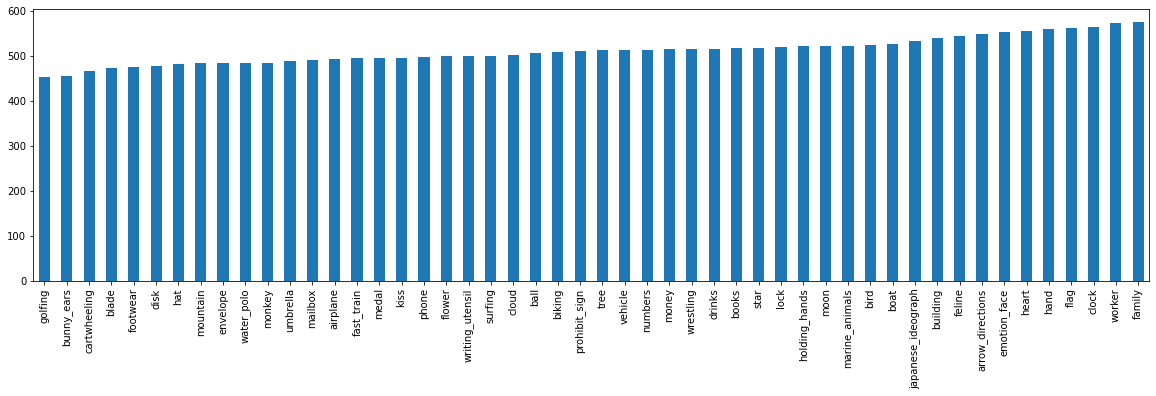

In [104]:
plt.figure(figsize=(20,5))
visualisation["label_name"].value_counts().sort_values().plot(kind = 'bar')
plt.show()

## III) Modeling et entraînement

### III.1 Approche Fine Tuning

In [12]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4
from tensorflow.keras import metrics
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, f1_score, accuracy_score

In [13]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


On définit nos hyperparamètres 

In [5]:
BATCH_SIZE = 32
NUM_CLASSES = 50
IMG_SIZE = 120

On doit à présent récupérer notre jeu d'entrainement et de test ainsi que le jeu de données Augmax :

In [6]:
train_val = pd.read_csv("train_val.csv")
test = pd.read_csv("test.csv")

data_augmix = pd.read_csv("data_augmix.csv")

**Important** : Rappelons-nous que nous avons générés de nouvelles images grâce à AugMix, nous voulons utiliser ces nouvelles images pour notre apprentissage mais nous devons faire attention à ne pas utiliser les images générées correspondant aux images de notre test set. Sinon on risque de biaiser les évaluations de notre modèle.

In [7]:
train_val = train_val.append(
    data_augmix[data_augmix["source"].isin(train_val["name"])]
)

Notre première approche consiste en un fine-tuning d'un EfficientNet-B0.   

Pour cela nous importons **EfficientNetB0** de keras application avec le paramètre weights à "imagenet" car nous voulons importer les poids du modèle entrainé sur ImageNet. ImageNet étant une base de données composées de plus d'un million d'images, les valeurs des kernels (= les poids du modèle) appris sur ImageNet sont de la grande valeur. Même si notre jeu de données ne ressemble pas exactement aux images d'ImageNet, il est souvent plus intéressant de récupérer les poids d'un modèle entrainé sur ImageNet que d'initialiser les poids de façon aléatoire.   

On ajoute 4 couches après notre backbone (EfficientNetB0):    
- Une couche de GlobalAveragePooling2D pour réduire la dimension des features maps de sortie du backbone et également "aplatir" la matrice (l'équivalent d'un reshape d'une matrice 3D à 2D)
- Suivi d'une couche de BatchNormalization qui fait office de régularisation
- Puis d'une couche de Dropout, toujours pour régulariser notre réseau
- Et enfin une couche de Dense avec softmax avec N (le nombre de neurones) égale à notre nombre de label

L'entrainement se fera en 2 temps :    
- Premièrement nous allons freeze toutes les couches de notre backbone (les couches d'EfficientNetB0) et entrainer avec un important learning (1e-2) puis le baisser progressivement jusqu'à (1e-4). Nous faisons cela car nous avons ajouter de nouvelle couches à notre réseau et nous voulons d'abord entrainer ces nouvelles couches afin de ne pas trop modifier les valeurs des poids du réseau au début de l'apprentissage, là où l'erreur sera la plus grande et donc le gradient élevée lors de la back propagation.   


- Dans un second temps, nous allons unfreeze la quasi-totalité du réseau et entrainer avec un faible learning rate (1e-4). Ce deuxième entrainement permet de spécialiser notre réseau dans son ensemble à la tache souhaitée.

In [14]:
def build_model(learning_rate=1e-2):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False
    
    output = model.output
  
    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(50, activation="softmax", name="logit")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNetb0")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro')]
    )
    return model

In [15]:
def run_train(model, train_generator, val_generator, epochs, save_weights="model_best.h5", verbose=1):
    def scheduler(epoch, lr):
        if epoch < 30:
            return lr
        if epoch < 100:
            return lr*0.1
        return lr*0.01

    if verbose > 0:
        print("First Training : Backbone freeze\n")
    
    freeze_hist = model.fit(train_generator, 
                            epochs=epochs, 
                            validation_data=val_generator, 
                            verbose=verbose,
                            use_multiprocessing = True,
                            max_queue_size=20,
                            workers = 20,
                            callbacks=[
                                tf.keras.callbacks.LearningRateScheduler(scheduler)
                            ])
    
    if verbose > 0:
        print("Second Training : Unfreeze all network and train with a small learning rate\n")
    
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, 
        loss="categorical_crossentropy", 
        metrics=["accuracy", 
            tfa.metrics.F1Score(num_classes=50, average='macro')
        ]
    )
    
    hist = model.fit(train_generator, 
                     epochs=100, 
                     validation_data=val_generator, 
                     verbose=verbose,
                     use_multiprocessing = True,
                     max_queue_size=20,
                     workers = 20,
                     callbacks=[
                         tf.keras.callbacks.ModelCheckpoint(filepath=save_weights, 
                                                            save_best_only=True, 
                                                            monitor="val_loss"),
                     ])
    
    return hist, freeze_hist

Maintenant on prépare notre fonction d'entrainement avec notre workflow de données :   
- Nous utilisons **ImageDataGenerator** qui permet d'appliquer de l'augmentation d'image de manière aléatoire et à la volée (c'est-à-dire pour chaque image)    
- Ensuite, nous utilisons la fonction flow_from_dataframe pour lier notre Generator à notre base d'entrainement.  

Dans la fonction **fit** nous devons définir trois paramètres importants afin d'avoir un workflow optimisé :    
- use_multiprocessing à True
- workers à 14 (A remplir en fonction du nombre de threads disponibles sur le CPU)
- max_queue_size > 10

Ces paramètres vont permettre au pipeline de prefetch les données lors de l'entrainement, ainsi le CPU va préparer les batchs d'image (avec augmentations) pendant le GPU fera l'entrainement. Prefetch les batchs en parallèle du GPU permet d'avoir un workflow optimisé ou le GPU est à 100% d'utilisation constante et de ne surtout pas créer de bottleneck ( à savoir le moment ou le GPU ne procède plus à l'entrainement car il attend le batch d'image du CPU )

In [16]:
def training(train_val, save_weights, epochs=200, verbose=1):
    
    train_df, val_df = train_test_split(
        train_val, 
        test_size=0.1, 
        stratify=train_val["label"]
    )
    
    if verbose > 0:
        print("Create ImageDataGenerator .. \n")
        
    train_datagen = ImageDataGenerator(
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        vertical_flip=True,
        channel_shift_range=0.3,
        brightness_range=[0.2,1.2]) # brightness

    datagen_val = ImageDataGenerator()
    
    train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, 
        directory="",
        x_col="name", 
        y_col="label_name", 
        class_mode="categorical", 
        target_size=(IMG_SIZE, IMG_SIZE), 
        batch_size=BATCH_SIZE,
        rescale=1.0/255,
        seed=2020 
    )
    
    val_generator = datagen_val.flow_from_dataframe(dataframe=val_df, 
      directory="",
      x_col="name", 
      y_col="label_name", 
      class_mode="categorical", 
      target_size=(IMG_SIZE, IMG_SIZE), 
      batch_size=BATCH_SIZE,
      rescale=1.0/255,
      seed=2020
    )
    if verbose > 0:
        print("\nBuild model .. \n")
        
    model = build_model()
    if verbose > 0:
        print("\nRun training .. \n")
        
    hist, freeze_hist = run_train(model, 
                            train_generator, 
                            val_generator, 
                            epochs=epochs,
                            save_weights=save_weights,
                            verbose = verbose
                        )
    
    return hist, freeze_hist

On peut procéder à l'apprentissage : 

In [11]:
hist, freeze_hist = training(train_val, "model_best.h5", epochs=150, verbose=1)

Create ImageDataGenerator .. 

Found 19580 validated image filenames belonging to 50 classes.
Found 2176 validated image filenames belonging to 50 classes.

Build model .. 


Run training .. 

First Training : Backbone freeze

Epoch 1/150
612/612 [==============================] - 40s 49ms/step - loss: 2.1515 - accuracy: 0.6622 - f1_score: 0.6615 - val_loss: 0.6322 - val_accuracy: 0.8548 - val_f1_score: 0.8545
Epoch 2/150
612/612 [==============================] - 28s 45ms/step - loss: 1.0253 - accuracy: 0.7657 - f1_score: 0.7658 - val_loss: 0.5354 - val_accuracy: 0.8589 - val_f1_score: 0.8604
Epoch 3/150
612/612 [==============================] - 28s 44ms/step - loss: 0.8875 - accuracy: 0.7795 - f1_score: 0.7798 - val_loss: 0.4326 - val_accuracy: 0.8860 - val_f1_score: 0.8857
Epoch 4/150
612/612 [==============================] - 30s 46ms/step - loss: 0.8345 - accuracy: 0.7908 - f1_score: 0.7909 - val_loss: 0.4702 - val_accuracy: 0.8750 - val_f1_score: 0.8749
Epoch 5/150
612/612 [====

/home/yannis/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
612/612 [==============================] - 34s 52ms/step - loss: 0.6352 - accuracy: 0.8861 - f1_score: 0.8867 - auc: 0.9766 - val_loss: 0.2447 - val_accuracy: 0.9513 - val_f1_score: 0.9521 - val_auc: 0.9922
Epoch 3/100
612/612 [==============================] - 33s 51ms/step - loss: 0.6110 - accuracy: 0.8889 - f1_score: 0.8892 - auc: 0.9781 - val_loss: 0.2199 - val_accuracy: 0.9577 - val_f1_score: 0.9582 - val_auc: 0.9925
Epoch 4/100
612/612 [==============================] - 34s 51ms/step - loss: 0.5311 - accuracy: 0.8997 - f1_score: 0.9001 - auc: 0.9808 - val_loss: 0.1779 - val_accuracy: 0.9628 - val_f1_score: 0.9631 - val_auc: 0.9939
Epoch 5/100
612/612 [==============================] - 34s 52ms/step - loss: 0.5099 - accuracy: 0.9027 - f1_score: 0.9030 - auc: 0.9823 - val_loss: 0.1597 - val_accuracy: 0.9665 - val_f1_score: 0.9670 - val_auc: 0.9946
Epoch 6/100
612/612 [==============================] - 35s 53ms/step - loss: 0.4924 - accuracy: 0.9044 - f1_score: 0.9049 - 

------------------------------ First training ------------------------------


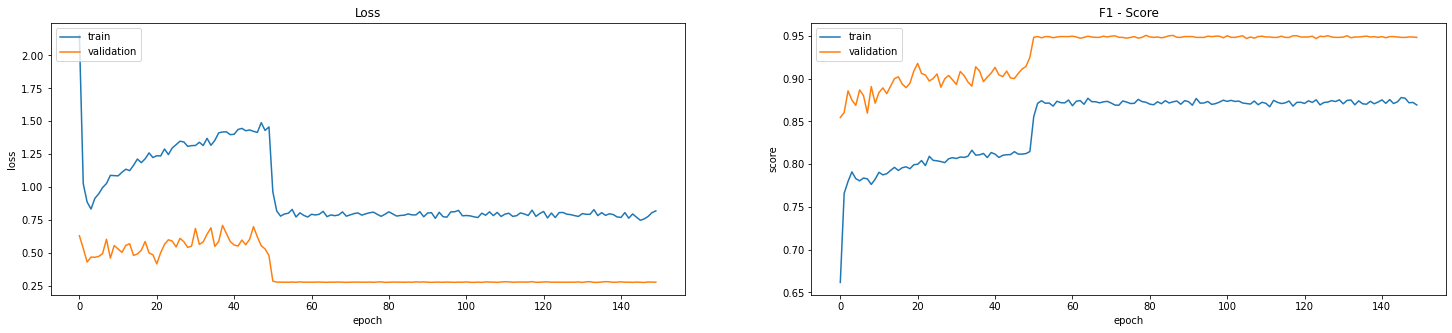

------------------------------ Second training ------------------------------


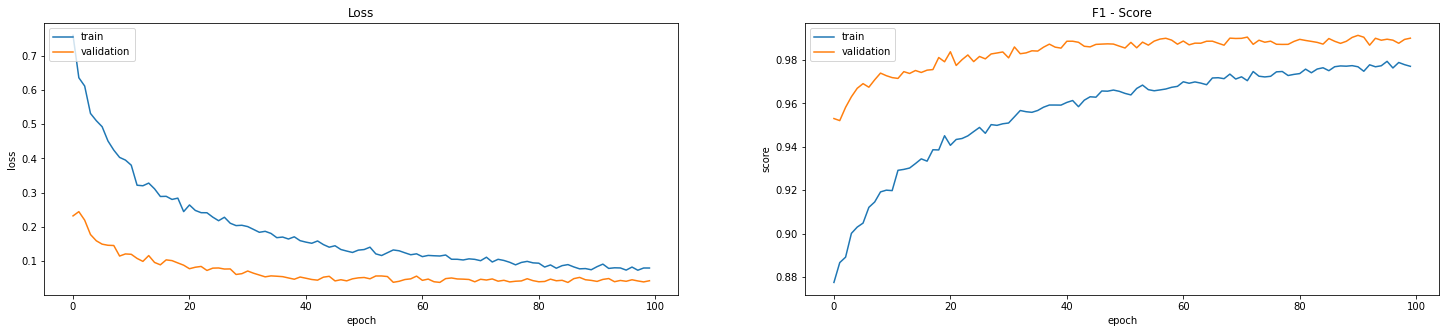

In [18]:
####################################################################################
############# Executer les fonctions utiles à la fin du notebook avant #############
####################################################################################

plot_history(freeze_hist, name = "First training")
plot_history(hist, name = "Second training")

Nous pouvons observer que durant notre premier apprentissage (avec le backbone freeze), notre modèle est capable d'atteindre des très bonnes performances juste en apprenant les dernières couches. Cela nous montre que les poids d'ImageNet sont très utiles. On peut aussi noter que le modèle semble converger rapidement avec un learning rate à 1e-3. Il aurait pu être intéressant d'ajouter de **l'EarlyStopping** à notre workflow d'apprentissage, cela aurait pu nous faire gagner du temps.   

Lors du second entrainement (le réseau unfreeze), on peut voir que la "spécialisation" permet de gagner en performances. Le modèle continue à apprendre et semble bien converger.    

Autre point intéressant : On peut observer l'impact de nos régularisations sur la loss et le f1_score. La loss est plus élevée durant notre apprentissage que durant l'évaluation, pareil pour le f1_score qui est meilleur en validation qu'en apprentissage. Ceci s'explique par :
- Notre couche de BatchNorm et dropout juste avant la couche de logit
- La data augmentation (+ AugMix)

Une fois notre modèle entrainé, les poids du meilleur réseau ont été sauvegardés dans un fichier model_best.h5.  

Nous rechargeons le modèle afin de l'évaluer sur notre jeu de test.   

In [69]:
model = keras.models.load_model('model_best.h5')

In [79]:
####################################################################################
############# Executer les fonctions utiles à la fin du notebook avant #############
####################################################################################
report = report_evaluation(model, test)

------------------------------ Evaluation Report ------------------------------ 

Test Size : Found 1500 validated image filenames.

Report : 

F1_score macro: 0.9806221814345573
Accuracy:  0.9813333333333333

                     precision    recall  f1-score   support

          airplane       1.00      0.82      0.90        11
  arrow_directions       0.97      0.98      0.97        59
              ball       0.97      1.00      0.98        29
            biking       1.00      1.00      1.00        15
              bird       1.00      0.91      0.95        34
             blade       1.00      1.00      1.00        14
              boat       1.00      1.00      1.00        43
             books       0.97      1.00      0.98        31
          building       0.98      0.94      0.96        47
        bunny_ears       1.00      0.96      0.98        24
      cartwheeling       1.00      1.00      1.00        16
             clock       1.00      1.00      1.00        63
        

Dans l'ensemble, on peut voir que le modèle obtient des performances plutôt homogènes sur toutes les classes.   
Seul la classe "monkey" possède un f1_score en dessous de 90%.

L'accuracy et le F1 score nous donne les mêmes performances

## IV) Analyse des erreurs

Une étape importante dans la conception d'un modèle est d'essayer de comprendre et d'expliquer certaines de ces erreurs. Pour cela on va regarder les images sur lesquelles le modèle s'est trompé dans la prédiction et nous allons afficher les images. 

In [14]:
import cv2

In [16]:
model = keras.models.load_model('model_best.h5')

In [17]:
####################################################################################
############# Executer les fonctions utiles à la fin du notebook avant #############
####################################################################################
_, _, y_pred, y_test, _ = report_evaluation(model, test, verbose=0)

Found 1500 validated image filenames.


In [18]:
list_images = test["name"]
classes_indices = pd.Categorical(test["label_name"]).categories

In [19]:
index_errors = np.where(np.array(y_pred) != np.array(y_test))[0]

In [20]:
index_errors

array([   0,   32,   33,   49,  177,  195,  277,  333,  412,  492,  561,
        608,  611,  614,  630,  709,  730,  753,  795,  825,  826,  887,
        902,  914,  982, 1015, 1045, 1173])

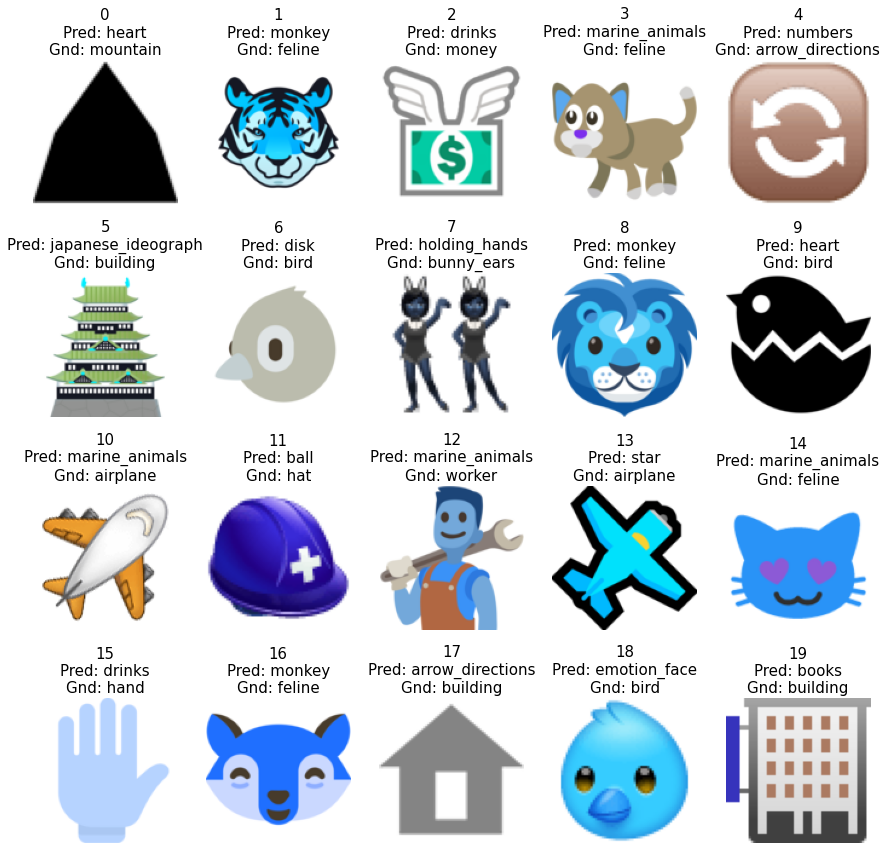

In [45]:
idx = 1
plt.figure(figsize=(15,15))
for n,e in enumerate(index_errors[:20]):
    e_image = list_images[e]
    
    prediction = classes_indices[y_pred[e]]
    groundtruth = classes_indices[y_test[e]]

    
    plt.subplot(4,5,idx)
    plt.title("{0}\nPred: ".format(n)+ str(prediction)+"\nGnd: "+str(groundtruth), fontsize=15)
    plt.imshow(cv2.imread(e_image))
    plt.axis("off")
    idx += 1 

- Concernant les cas **19,17,11,6:** On comprend intuitivement que la forme de l'image a trompé le réseau. Le 17 a une forme de flèche alors qu'il est censé représenter une maison. De même pour le 6, la forme ronde du "bird" a amené le réseau à prédire "disk":    

    -> Solution potentielle: Une augmentation plus prononcée dans la déformation de l'image (shift, shread, rotation) aurait pu rendre le modèle plus robuste à ce type d'erreur  

- Pour les cas **1,3,8,14,16**: L'erreur semble correspondance à des groupes de classes. Les classes représentant des animaux sont riches et avec une grande variété de styles différentes. La classe "Feline" par exemple regroupe un ensemble d'émoticônes très varié : des images avec un gros plan sur la "tête" du Félin, d'autres de côté avec le "corps" entier et dans plein de couleurs différence, "monkey" regroupe plus d'image au teint maron, "marine_animals" plutôt bleu  

  -> Solution potentielle: Une augmentation plus prononcée dans la colorimétrie de l'image (random grayscale, color shift, channel shift, brightness, contraste, saturation) aurait pu forcer le modèle à moins baser sa prédiction sur les couleurs mais plus sur la forme

Pour les cas restants, notamment le 0 et 4, nous arrivons surement aux limites de la capacité de généralisation de notre modèle sur certains styles. On peut tout de même essayer de comprendre l'erreur en faisant de la recherche de similarité sur l'embedding construit par le réseau pour chaque image.    

Pour cela nous allons procéder ainsi:

1. Nous allons reprendre notre réseau entrainé et modifier l'architecture pour ne pas prendre la sortie de la dernière couche (softmax) mais la sortie de l'avant-dernière couche (la couche de GlobalAveragePooling). Ce vecteur de taille 1280 correspond à "l'embedding" (la représentation numérique) d'une image. 

2. On extrait ainsi l'embedding de toutes les images de notre jeu de test ainsi que notre jeu d'entrainement

3. Pour chaque embedding (image) du jeu de test, on va récupérer les N plus proche embedding (image) dans le jeu d'entrainement. Pour cela on effectue un calcul de distance cosinus.

4. Enfin, pour chaque embedding (image) de notre jeu de test où la prédiction a été fausse, on affiche les images les plus proches.



(Le code est disponible ici [Test_retrieval_errors](https://github.com/yannistannier/Icons50-bonus/blob/master/Test_retrieval_errors.ipynb) )

Ainsi on obtient le résultat suivant :

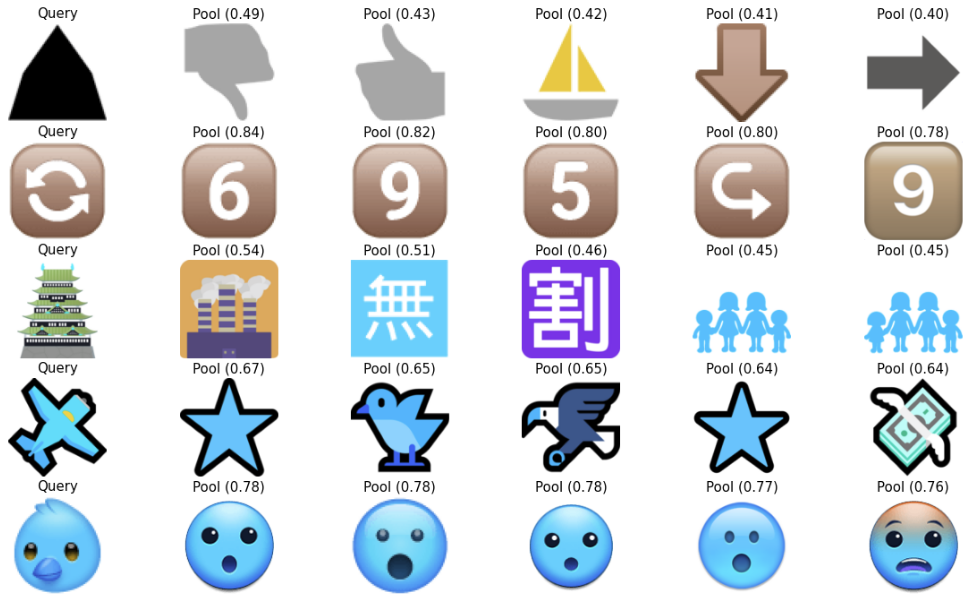

## V)  Cross validation

La prochaine et dernière étape est d'évaluer notre approche par validation croisée afin d'avoir une évaluation plus robuste.  


Récupérons notre jeu de données entier : data.csv

In [22]:
from sklearn.model_selection import KFold

df = pd.read_csv("data.csv")
data_augminx = pd.read_csv("data_augmix.csv")

df.head()

,name,label_name,label
0,./Icons-50/writing_utensil/samsung_4_lower_lef...,writing_utensil,49
1,./Icons-50/writing_utensil/twitter_0_pencil.png,writing_utensil,49
2,./Icons-50/writing_utensil/whatsapp_0_lower_le...,writing_utensil,49
3,./Icons-50/writing_utensil/microsoft_4_black_n...,writing_utensil,49
4,./Icons-50/writing_utensil/samsung_3_black_nib...,writing_utensil,49


Maintenant que nous avons notre Dataframe, nous pouvons diviser notre jeu de données en plusieurs jeux d'entrainement et de test grâce à la fonction KFold de Sklearn.   

Nous mettons un random_state afin de pouvoir à tout moment refaire toutes nos expérimentations avec les mêmes paramètres.  

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

**Important** : Rappelons-nous que nous avons générés de nouvelles images grâce à AugMix, nous voulons utiliser ces nouvelles images pour notre apprentissage mais nous devons faire attention à ne pas utiliser les images générées correspondant aux images de notre test set. Ce qui reviendrait à tester sur des images d'entrainements, biaisant complètement notre évaluation.  

Pour cela on importe data_augmix et on ajoutera au jeu d'entrainement uniquement les nouvelles images générées correspondant aux images source du jeu d'entrainement, et on ignore toutes les images générées issues des images source de test.  

Et enfin, pour chacun des Folds nous allons entrainer un modèle puis évaluer le f1_score et l'accuracy

In [24]:
cv_f1_score = []
cv_accuracy = []

for k, (train_index, test_index) in enumerate(kf.split(df)):
    print("##### Fold {0} #####".format(k))
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]
    
    train_augmix = data_augminx[data_augminx["source"].isin(train_df["name"])]
    
    train_df = train_df.append(train_augmix)
    
    
    _, _ = training(train_df, "./kfold/model_k{0}.h5".format(k), epochs=150, verbose=0)
    
    model = keras.models.load_model("./kfold/model_k{0}.h5".format(k))
    report = report_evaluation(model, test_df, verbose=0)
    
    cv_f1_score.append(report[0])
    cv_accuracy.append(report[1])


##### Fold 0 #####
Found 18514 validated image filenames belonging to 50 classes.
Found 2058 validated image filenames belonging to 50 classes.


/home/yannis/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Found 2000 validated image filenames.
##### Fold 1 #####
Found 18363 validated image filenames belonging to 50 classes.
Found 2041 validated image filenames belonging to 50 classes.


/home/yannis/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Found 2000 validated image filenames.
##### Fold 2 #####
Found 18453 validated image filenames belonging to 50 classes.
Found 2051 validated image filenames belonging to 50 classes.


/home/yannis/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Found 2000 validated image filenames.
##### Fold 3 #####
Found 18360 validated image filenames belonging to 50 classes.
Found 2041 validated image filenames belonging to 50 classes.


/home/yannis/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Found 2000 validated image filenames.
##### Fold 4 #####
Found 18348 validated image filenames belonging to 50 classes.
Found 2039 validated image filenames belonging to 50 classes.


/home/yannis/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Found 2000 validated image filenames.


In [28]:
print("F1 score mean", np.mean(cv_f1_score))
print("Accuracy score mean", np.mean(cv_accuracy))

F1 score mean 0.9675521547343132
Accuracy score mean 0.9719000000000001


## Annexe :  Fonctions utiles

In [7]:
def plot_history(hist, name = "Training"):
    print("-"*30, name, "-"*30)
    plt.figure(figsize=(25,5))
    
    plt.subplot(1,2,1)
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["validation", "train"], loc="upper left")
    
    plt.subplot(1,2,2)
    plt.plot(hist.history["f1_score"])
    plt.plot(hist.history["val_f1_score"])
    plt.title("F1 - Score")
    plt.ylabel("score")
    plt.xlabel("epoch")
    plt.legend(["validation", "train"], loc="upper left")
    
    plt.show()

In [8]:
def report_evaluation(model, test_df, image_size=120, batch_size=32, verbose = 1):
    
    if verbose > 0:
        print("-"*30,"Evaluation Report","-"*30,"\n")
    datagen_test = ImageDataGenerator()
    
    if verbose > 0:
        print("Test Size :", end=' ')
    test_generator = datagen_test.flow_from_dataframe(dataframe=test_df, 
        x_col="name",
        shuffle=False,
        target_size=(image_size,image_size), 
        batch_size=batch_size,
        class_mode=None,
        rescale=1.0/255,
        seed=2020 )
    
    if verbose > 0:
        print("\nReport : \n")
    probabilities = model.predict(test_generator)
    y_pred = np.argmax(probabilities,1)
    y_test = np.array(test_df["label"])
    
    score_f1 = f1_score(y_test, y_pred, average="macro")
    score_acc = accuracy_score(y_test, y_pred)
    
    if verbose > 0:
        print("F1_score macro:", score_f1)
        print("Accuracy: ", score_acc)
    
        class_indices = test_df["label_name"].cat.categories.tolist()
    
        print("\n",classification_report(y_test, y_pred, target_names=class_indices))
    
    return score_f1, score_acc, y_pred, y_test, np.max(probabilities,1)